In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import numpy as np

# Display fixed length of a dataframe
pd.set_option("display.max_rows", 9, "display.max_columns", 9)

from prophet import Prophet

# #from arch import arch_model
# from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler
# from sklearn import linear_model

# from statsmodels.tsa.seasonal import seasonal_decompose
# from statsmodels.tsa.arima.model import ARIMA
# #from statsmodels.tsa.stattools import adfuller
# #import statsmodels.graphics.tsaplots as sgt

from warnings import filterwarnings
filterwarnings("ignore")

In [43]:
# from joblib import dump
# import pickle

#set path
import sys
import os
sys.path.insert(1, '../')
from utils.config_reader import config_reader

# Import parameters
config = config_reader('../config/config.json')

random_seed = config.random_seed
path_figures = config.path_figures
 
os.environ['PYTHONHASHSEED'] = str(random_seed)
np.random.seed(random_seed)

from utils.functions import Dickey_Fuller_test, optim_param, plot_acf_pacf

# Read data

In [44]:
data = pd.read_csv("../data/books.zip") #, parse_dates=["published_year"]
data.head()

,isbn13,isbn10,title,subtitle,...,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,...,1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,...,2002.0,4.15,170.0,33684.0


In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


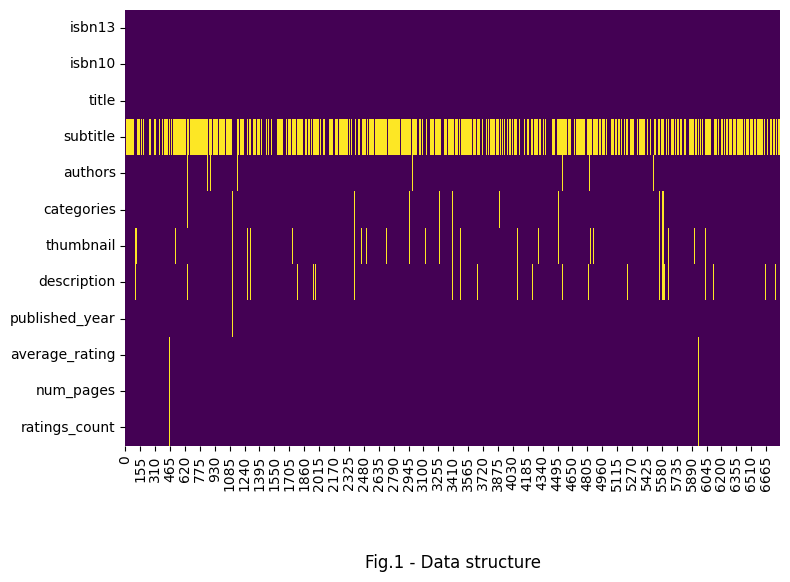

In [46]:
fig_id = 1
plt.figure(figsize=(8,6))
fig = sns.heatmap(data.isna().transpose(), cbar=False, cmap='viridis')
#ticks_y = ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y/scale_factor_y))
#fig.yaxis.set_major_formatter(ticks_y)
#fig.yaxis.grid(linestyle=':')

plt.title("Fig.{} - Data structure".format(fig_id), y=-0.3)
#plt.ylabel("Billions usd")
plt.tight_layout()
#plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'));

In [47]:
# difference between current year and the year of book publishing
data['book_age'] = (2025 - data["published_year"])
# mask = data['book_age'].isna() == True
# data[~mask]['book_age'] = data[~mask]['book_age'].astype('int16')
data.head()

,isbn13,isbn10,title,subtitle,...,average_rating,num_pages,ratings_count,book_age
0,9780002005883,0002005883,Gilead,NaN,...,3.85,247.0,361.0,21.0
1,9780002261982,0002261987,Spider's Web,A Novel,...,3.83,241.0,5164.0,25.0
2,9780006163831,0006163831,The One Tree,NaN,...,3.97,479.0,172.0,43.0
3,9780006178736,0006178731,Rage of angels,NaN,...,3.93,512.0,29532.0,32.0
4,9780006280897,0006280897,The Four Loves,NaN,...,4.15,170.0,33684.0,23.0


In [48]:
mask = data['description'].isna() == True
data[mask]

,isbn13,isbn10,title,subtitle,...,average_rating,num_pages,ratings_count,book_age
37,9780006906018,000690601X,The Princess of the Chalet School,NaN,...,4.10,159.0,446.0,25.0
60,9780007127740,000712774X,The illustrated man,NaN,...,4.14,186.0,56781.0,23.0
99,9780020442806,0020442807,"The Chronicles of Narnia: Lion, the witch and ...",NaN,...,4.26,1425.0,1446.0,47.0
102,9780023513206,0023513209,Reason in History,A General Introduction to the Philosophy of Hi...,...,3.64,95.0,430.0,72.0
...,...,...,...,...,...,...,...,...,...
6787,9783464371640,3464371646,About a Boy,NaN,...,3.80,256.0,155.0,23.0
6788,9783540292128,3540292128,Enzyme-Catalyzed Synthesis of Polymers,NaN,...,0.00,254.0,0.0,19.0
6806,9788185944609,8185944601,Secrets Of The Heart,NaN,...,4.08,74.0,324.0,32.0
6807,9788445074879,8445074873,Fahrenheit 451,NaN,...,3.98,186.0,5733.0,21.0


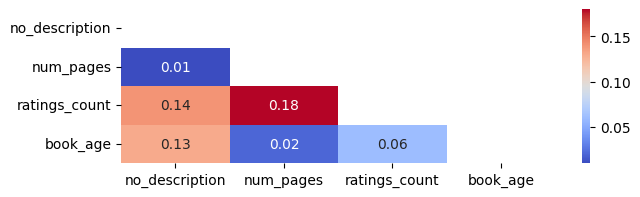

In [49]:
# check if there is a correlation between missing description and other features
data['no_description'] = np.where(data['description'].isna(), 1, 0)
cols = ['no_description', 'num_pages', 'ratings_count', 'book_age']

fig = plt.figure(figsize=(7, 2))
matrix = np.triu(data[cols].corr(method="spearman", numeric_only=True))
sns.heatmap(round(abs(data[cols].corr(method="spearman", numeric_only=True)), 2), 
    annot=True, cmap= 'coolwarm', mask=matrix);

The heatmap indicates that there is almost no correlation between the absence of description and other featurees. Let us separate them to another dataset.

In [38]:
# col = ['description', 'published_year', 'average_rating', 'num_pages']
#     #'isbn13', 'isbn10', 'title',  'authors', 'categories', #'subtitle'
#     #'thumbnail',  'ratings_count', 'book_age', 'no_description']
# mask = data[col].isna() == True
# data, data_missing = data[mask], data[~mask]

In [41]:
data

,isbn13,isbn10,title,subtitle,...,num_pages,ratings_count,book_age,no_description
0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
6806,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
6807,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
6808,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN
6809,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN


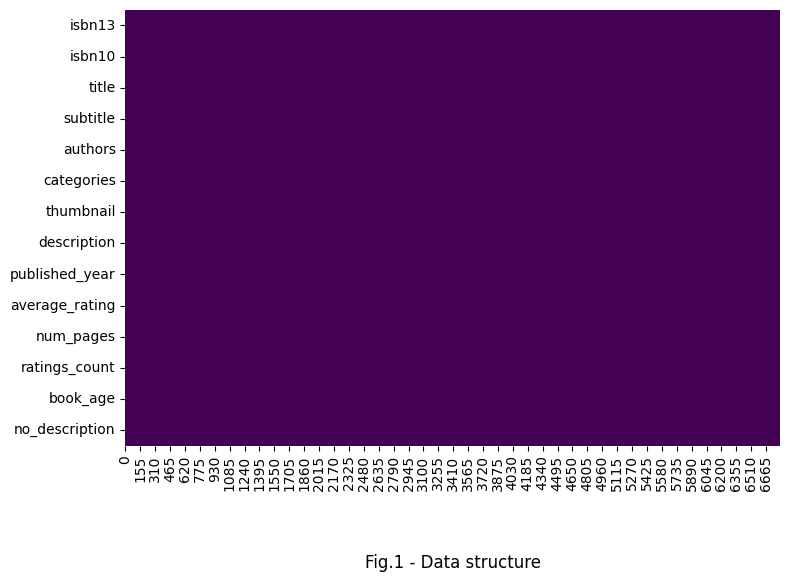

In [39]:
fig_id = 1
plt.figure(figsize=(8,6))
fig = sns.heatmap(data_missing.isna().transpose(), cbar=False, cmap='viridis')
#ticks_y = ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y/scale_factor_y))
#fig.yaxis.set_major_formatter(ticks_y)
#fig.yaxis.grid(linestyle=':')

plt.title("Fig.{} - Data structure".format(fig_id), y=-0.3)
#plt.ylabel("Billions usd")
plt.tight_layout()
#plt.savefig(os.path.join(path_figures, f'fig_{fig_id}.png'));

In [21]:
data.isna().sum()

isbn13            6810
isbn10            6810
title             6810
subtitle          6810
                  ... 
num_pages           43
ratings_count     6810
book_age          6810
no_description    6810
Length: 14, dtype: int64

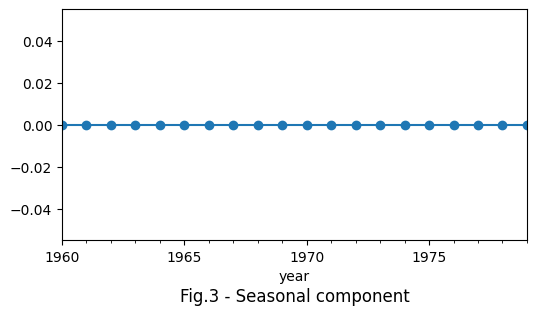

In [7]:
fig_id = 3
plt.figure(figsize=(6,3))
result.seasonal[:20].plot(marker="o")
plt.title('Fig.{} - Seasonal component'.format(fig_id), y=-0.3)
plt.show()

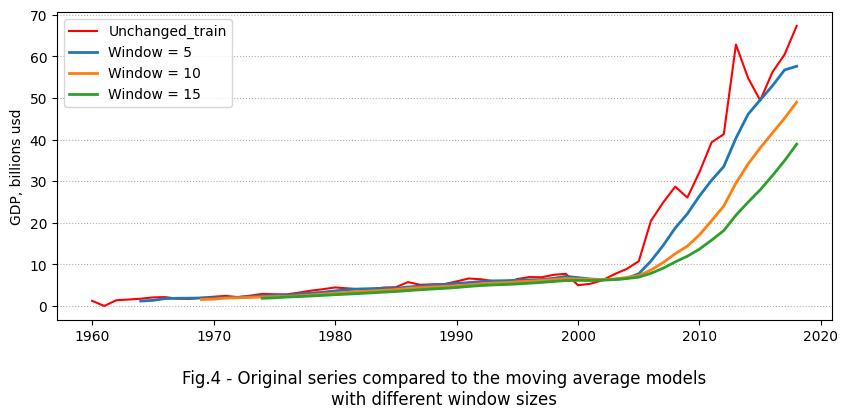

In [ ]:
fig_id = 4
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(train, color="red", label="Unchanged_train")
scale_factor_y = 1e9
ticks_y = ticker.FuncFormatter(lambda y, pos: '{:.0f}'.format(y/scale_factor_y))
ax.yaxis.set_major_formatter(ticks_y)
ax.yaxis.grid(linestyle=':')

window = np.linspace(5,15,3).astype("int8") # Set 3 window sizes: 5,10,15

for i in range(window.shape[0]):
    ax.plot(
        train.rolling(window=window[i]).mean(),
        label="Window = {}".format(window[i]),
        linewidth=2
    )
plt.ylabel("GDP, billions usd")
plt.legend()
plt.title("Fig.{} - Original series compared to the moving average models\nwith different window sizes".format(fig_id), y=-0.3);

### ARIMA

In [49]:
p = 2 # last significant lag taken from the partial autocorrelation graph
d = diff_order # difference order
q = 1 # last significant lag taken from the  autocorrelation graph
arima_model = ARIMA(train_diff, order=(p, d, q))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           train_scaled   No. Observations:                   56
Model:                 ARIMA(2, 3, 1)   Log Likelihood                 -61.905
Date:                Sun, 17 Mar 2024   AIC                            131.809
Time:                        20:38:48   BIC                            139.691
Sample:                    01-01-1963   HQIC                           134.840
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.3644      0.041    -33.056      0.000      -1.445      -1.284
ar.L2         -0.8101      0.035    -23.433      0.000      -0.878      -0.742
ma.L1         -0.9991      7.648     -0.131      0.896     -15.989      13.991
sigma2         0.5087      3.872      0.131      0.895      -7.079       8.097
===================================================================================
Ljung-Box (L1) (Q):                   4.56   Jarque-Bera (JB):                51.56
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):             191.08   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2.3 Обратите внимание, что иногда пропуски в данных могут быть заполнены нулями. Сделайте проверку на наличие нулевых значений и в случае нахождения замените их на NaN.

In [24]:
# replace null data with nan-values
data['GDP'] = data['GDP'].apply(lambda x: np.nan if x==0 else x)
data.isna().sum()

GDP    1
dtype: int64

In [25]:
# u=interpolation of to replace missing entries
data['GDP'] = data['GDP'].interpolate(method='linear')
assert data['GDP'].isna().sum() == 0

#### linear model

In [38]:
X_train, X_test = np.arange(train.shape[0]).reshape(-1, 1), np.arange(test.shape[0]).reshape(-1, 1) #.fillna(0)
y_train, y_test = train.values, test.values

In [39]:
# Instance
lr = linear_model.LinearRegression()

lr.fit(X_train, y_train)
predictions_df['linear_predictions'] = lr.predict(X_test)

print("Root Mean Squared Error: {:.1f}".format(np.sqrt(mean_squared_error(
    predictions_df["volatility"].abs(), predictions_df["linear_predictions"]).round(2))))

display(predictions_df)

Root Mean Squared Error: 5.6


,volatility,arch_predictions,linear_predictions
year,,,
2019-01-01,1.542746,288.546011,8.641577
2020-01-01,2.495937,292.216032,8.788200
2021-01-01,10.780603,295.886053,8.934823


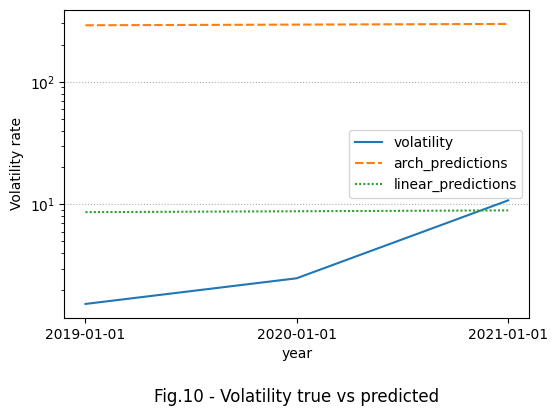

In [40]:
fig_id = 10
plt.figure(figsize=(6,4))
fig = sns.lineplot(predictions_df)

plt.xticks(test.index)
fig.yaxis.grid(linestyle=':')
plt.yscale('log')

plt.title("Fig.{} - Volatility true vs predicted".format(fig_id), y=-0.3)
plt.ylabel("Volatility rate")
plt.show();

3.5 Сравните результаты и сделайте выводы.

> Although the linear model predicts volatility up to the scale, it does not reflect any change in volatility in contrast to the arch model. The latter model, however, is very imprecise. Its large mean squared error metric was likely caused by limitation of test dataset.

# Prophet